# Notebook to reproduce Supplementary Figure 2

In [2]:
import os
import sys
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import FormatStrFormatter

sys.path.append(os.path.join(sys.path[0], '../'))
from plot import plot_settings, plot_utils
from gemini.func import textread
from config import GEMINI_DIR

In [3]:
fig_dir = 'figure/supplementary_figure_2/'
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

# Load results

In [4]:
result_df = {'net': [], 'method': [], 'species': [], 'subontology': [], 'mean max f1': [], 'std dev max f1': [],
             'mean macro AUPRC': [], 'std dev macro AUPRC': [], 'mean micro AUPRC': [], 'std dev micro AUPRC': []}
for net in ['String', 'BioGrid', 'Combo']:
    for method in ['gemini', 'mashup', 'bionic']:
        with open(GEMINI_DIR + 'results/{}/{}/results_by_subontology.txt'.format(net, method.upper()), 'r') as f:
            res = json.load(f)
        for sp in ['mouse', 'human', 'yeast']:
            if method == 'bionic' and (sp != 'yeast' and net != 'String'):
                continue
            for subont in ['MF', 'BP', 'CC']:
                result_df['net'].append(net)
                result_df['method'].append(method)
                result_df['species'].append(sp)
                result_df['subontology'].append(subont)
                result_df['mean max f1'].append(np.mean(res[sp][subont]['f1']))
                result_df['std dev max f1'].append(np.std(res[sp][subont]['f1']))
                result_df['mean micro AUPRC'].append(np.mean(res[sp][subont]['micro']))
                result_df['std dev micro AUPRC'].append(np.std(res[sp][subont]['micro']))
                result_df['mean macro AUPRC'].append(np.mean(res[sp][subont]['macro']))
                result_df['std dev macro AUPRC'].append(np.std(res[sp][subont]['micro']))

result_df = pd.DataFrame.from_dict(result_df)
result_df.head()

,net,method,species,subontology,mean max f1,std dev max f1,mean macro AUPRC,std dev macro AUPRC,mean micro AUPRC,std dev micro AUPRC
0,String,gemini,mouse,MF,0.438026,0.007074,0.092608,0.007396,0.389458,0.007396
1,String,gemini,mouse,BP,0.353633,0.003886,0.047774,0.003745,0.294054,0.003745
2,String,gemini,mouse,CC,0.474676,0.006285,0.086654,0.007172,0.424841,0.007172
3,String,gemini,human,MF,0.459162,0.004446,0.110272,0.006886,0.429303,0.006886
4,String,gemini,human,BP,0.406484,0.005145,0.084508,0.008654,0.368001,0.008654


# Now make the plot

In [5]:
subparts = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i']
sp_ordering = [sp for sp in ['mouse', 'human', 'yeast'] for _ in range(3)]
met_ordering = [met for _ in range(3) for met in ['max f1', 'macro AUPRC', 'micro AUPRC']]
sp_ordering[:5], met_ordering[:5]

(['mouse', 'mouse', 'mouse', 'human', 'human'],
 ['max f1', 'macro AUPRC', 'micro AUPRC', 'max f1', 'macro AUPRC'])

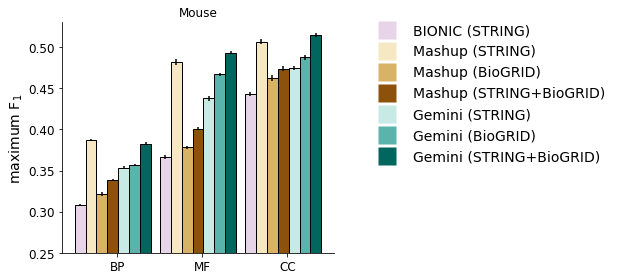

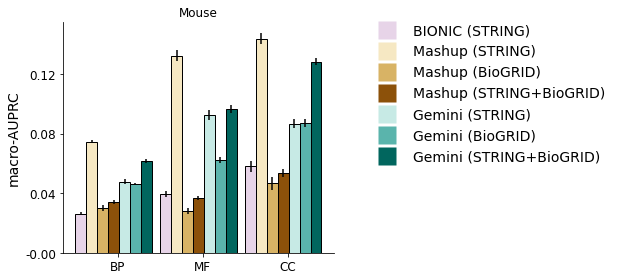

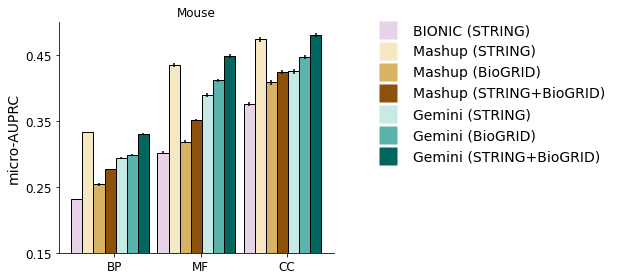

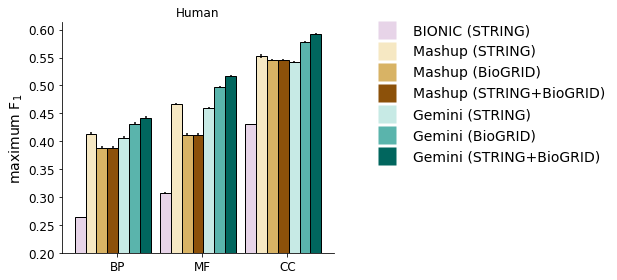

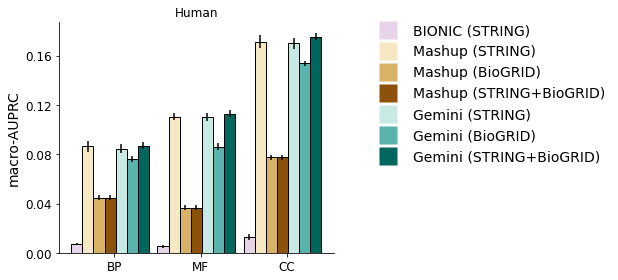

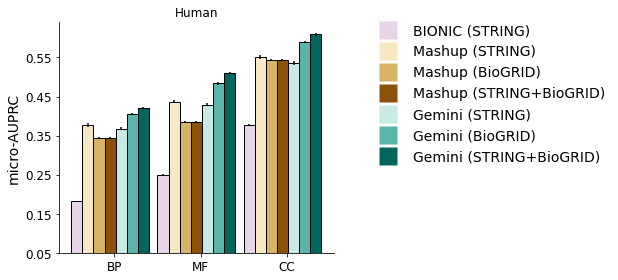

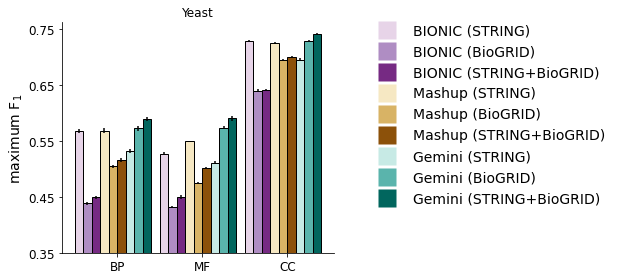

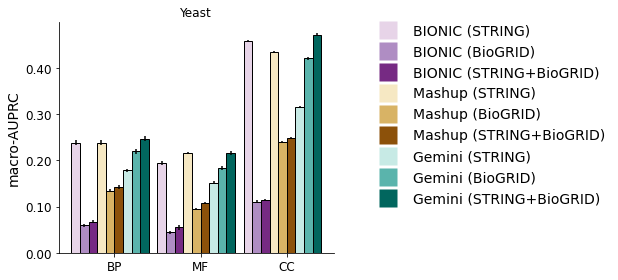

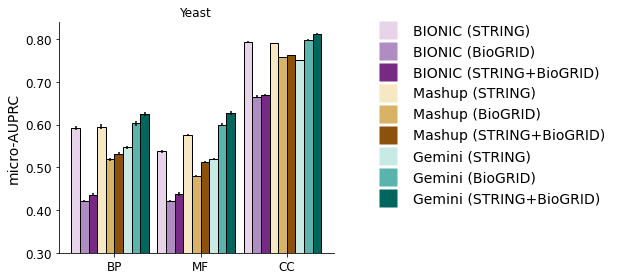

In [12]:
%matplotlib inline
for i in range(len(subparts)):
    org = sp_ordering[i]
    met = met_ordering[i]
    
    ax = plot_settings.get_wider_axis(scale=2.3)
    model_ordering = plot_settings.get_model_ordering(['gemini', 'mashup', 'bionic'])
    net_ordering = plot_settings.get_network_ordering()
    
    means = []
    std_errs = []
    nested_colors = []
    nested_colornames = []
    ont_ordering = ['BP', 'MF', 'CC']
    for subontology in ont_ordering:
        smeans, serrs, scols, scolnames = [], [], [], []
        dfOI = result_df[result_df['subontology'] == subontology]
        for mod in model_ordering:
            for net in net_ordering:
                if mod == 'bionic' and org != 'yeast' and net != 'String':
                    continue
                smeans.append(
                    dfOI[(dfOI['method'] == mod.lower()) & (dfOI['net'] == net) & (dfOI['species'] == org)]['mean {}'.format(met)].iloc[0])
                serrs.append(
                    dfOI[(dfOI['method'] == mod.lower()) & (dfOI['net'] == net) & (dfOI['species'] == org)]['std dev {}'.format(met)].iloc[0] / np.sqrt(5.))
                scols.append(plot_settings.get_model_colors_by_network(mod, net))
                scolnames.append('{} ({})'.format(plot_settings.get_model_name_conventions(mod),
                                                   plot_settings.get_network_naming_convention(net)))
        means.append(smeans)
        std_errs.append(serrs)
        nested_colors.append(scols)
        nested_colornames.append(scolnames)

    min_val = plot_utils.out_min_val(means, 1/4)
    plot_utils.grouped_barplot_variable_inputs(
        ax, means, ont_ordering, xlabel='', ylabel=plot_settings.get_metric_name(met),
        nested_color_legend=None, nested_color=nested_colors,
        nested_errs=std_errs, tickloc_top=False, min_val=min_val, rotangle=0)
    ytickstep = 0.05 if met == 'max f1' and org != 'yeast' else 0.1 if met == 'max f1' and org == 'yeast' \
        else 0.1 if met == 'micro AUPRC' else 0.04 if org != 'yeast' else 0.1
    ymin, ymax = ax.get_ylim()
    ax.yaxis.set_ticks(np.arange(ymin, ymax+ytickstep/2., ytickstep))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    
    # identify all of the unique (color, label) combinations
    complete_col_list = [plot_settings.get_model_colors_by_network(mod, net) 
                         for mod in model_ordering for net in net_ordering
                         if org == 'yeast' or (mod != 'bionic' or net == 'String')]
    lp = lambda i: plt.plot([],[],color=complete_col_list[i], ms=18, mec="none",
                            label=nested_colornames[-1][i], ls="", marker='s')[0]
    handles = [lp(i) for i in range(len(nested_colornames[-1]))]
    
    plot_utils.format_legend(ax, handles, nested_colornames[-1])
    plot_utils.put_legend_outside_plot(ax)
    
    plot_utils.format_ax(ax)
    plt.title(org[0].upper() + org[1:].lower())
    
    plt.tight_layout()
    plt.savefig(fig_dir + 'figure_S2_{}.pdf'.format(subparts[i]), bbox_inches='tight')